# Unlocking the Palate - Evaluating Taste Consensus Among Beer Reviewers

---

Group [**BlackAda**](https://en.wikipedia.org/wiki/Blackadder)

> - Ludek Cizinsky ([ludek.cizinsky@epfl.ch](ludek.cizinsky@epfl.ch))
> - Peter Nutter ([peter.nutter@epfl.ch](peter@nutter@epfl.ch))
> - Pierre Lardet ([pierre.lardet@epfl.ch](pierre@lardet@epfl.ch))
> - Christopher Bastin ([christopher.bastin@epfl.ch](christian@bastin@epfl.ch))
> - Mika Senghaas ([mika.senghaas@epfl.ch](mika@senghaas@epfl.ch))

📣 Note to TA for P2 \*This notebook runs a preliminary analysis on a subset of
10.000 reviews for computational efficiency. We attempt to show the feasibility
and correctness of implementation for the entire pipeline. Running the analysis
on the full dataset requires only to unset the `SUBSAMPLE` flag.\*\*


## Introduction

---

Navigating the world of beer reviews can be a daunting task for non-experts.
Beer aficionados often describe brews as having nuanced flavors such as "grassy
notes" and "biscuity/ crackery malt," with hints of "hay." But do these
descriptions reflect the actual tasting experience? Following a
"wisdom-of-the-crowd" approach, a descriptor can be considered meaningful if
many, independent reviewers use similar descriptors for a beer's taste. To
quantify consensus, we use natural language processing techniques to extract
descriptors of a beer's taste and numerically represent these descriptors to
compute similarity or consensus scores. The consensus scores between beer
reviews will unveil whether there is a shared understanding of taste among beer
geeks.


## Dependencies

---

We load the dependencies required for this project to run.


In [1]:
# Enable continuous module reloading
%load_ext autoreload
%autoreload 2

# Standard library
import os

# External library
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import spacy
from spacy.tokens import DocBin 
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.manifold import TSNE
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Custom modules
from src import utils
from src import extractors
from src import embedders
from src.consensus import ConsensusBase, CosineSimilarity, Correlation, KullbackLeiblerDivergence, JensenShannonDivergence
from src import visualise
from src.aggregator import EmbeddingAggregator

# from src import pipeline

And set some global variables.


In [2]:
# Plotting settings
from process_data import PROCESSED_DIR


colorstyle = "RdBu"
sns.set_style("dark")
sns.set_palette(colorstyle)

# Pandas settings
pd.options.display.max_colwidth = 150

# Load SpaCy model
NLP = spacy.load("en_core_web_sm", disable=["ner", "parser"])
DOC_BIN = DocBin(attrs=["LEMMA", "POS"])
LOAD_DOCS = True

# URL for the full dataset
DATA_URL = "https://drive.google.com/u/2/uc?id=1IqcAJtYrDB1j40rBY5M-PGp6KNX-E3xq&export=download"

# Subsetting options
SUBSET_DEMO = True
SUBSET_ANALYSIS = False
NUM_SUBSET_DEMO = 5000 # Expects that `process_data.py --limit NUM_SUBSET_SAMPLES`

# Paths
ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join(ROOT_DIR, "data")
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

# Random seed
SEED = 42
SHUFFLE_REVIEWS = False

# Type of metric
METRIC = "cosine"  # cosine, kl, js, correlation

# Ensure data directory exists
os.makedirs(DATA_DIR, exist_ok=True)

## Data

---

We will be working with the beer review data from the
[BeerAdvocate](https://www.beeradvocate.com/) platform.


### Data Download

Due to its size (uncompressed 1.6 GB), the dataset is not included in the
repository but must be downloaded. The course staff has provided the data via
Google Drive. On the first run of this notebook, we download the compressed data
file from Google Drive and extract it to the `data` folder. The compressed file
is ~1.5 GB in size.

After extraction and the removal of unnecessary files (archives, ratings file,
...), the data folder should contain the following files: `beers.csv`,
`breweries.csv`, `users.csv`, `reviews.txt`. The total size of the data is ~2.9
GB.

_NB: Data loading takes around **~8min** on the first run. Subsequent runs of
this cell are instant._


In [3]:
# Download the BeerAdvocate dataset if it doesn't exist
if not utils.raw_data_exists(DATA_DIR):
    utils.download_data(DATA_URL, data_dir=DATA_DIR)
print(f"Raw beer review data downloaded to {DATA_DIR} ✅.")

Raw beer review data downloaded to /Users/peter/Developer/ada-2023-project-blackada/data ✅.


### Data Processing

We would like to perform a series of pre-processing steps on the raw data to make it more amenable to analysis. These steps include:k

- Merge the reviews data with some additional meta-data about the beers, users
  and breweries (e.g. beer style, user location, ...) and collect in a singe
  multi-column DataFrame.
- We cast each column to the correct type, e.g. `date` is converted to a
  `datetime` object.
- We remove any reviews with any missing values (as there are only very few
  where this is the case)
- We drop columns that are not relevant for our analysis
- We rename columns and organise the DataFrame to have a multi-index with the
  reviews for easier access
- We compute `spacy` objects for each review which are crucial for extracting the
  taste descriptors from the reviews. This is a computationally expensive step
  and we therefore only compute the `lemma` and `pos` attributes of each token
  which are the only ones we need for our analysis.
- We add a new column `style` based on the `substyles` in the original data frame to have another way of grouping the beers

_NB: Procesing all `2.5M` reviews into `spacy` objects takes a long time (~2h). Furthermore, the data is very large due to the metadata that spacy stores for each token. We therefore only load a subset of the metadata as specified in the `DocBin` object which we will need for our later analysis - namely the `lemma` and `pos` attributes. This significantly reduces the disk and memory usage._

In [4]:
# Process the data if it hasn't been processed yet
if not utils.processed_data_exists(PROCESSED_DIR, NUM_SUBSET_DEMO if SUBSET_DEMO else None):
    utils.process_data(DATA_DIR, PROCESSED_DIR, NLP, DOC_BIN, NUM_SUBSET_DEMO if SUBSET_DEMO else None)

print(f"Processed beer review data saved to {PROCESSED_DIR} ✅.")

Processed beer review data saved to /Users/peter/Developer/ada-2023-project-blackada/data/processed ✅.


### Data Loading

Next, we load the data into a Pandas DataFrame. On the first run, we load all
the reviews from the `reviews.txt` file and populate it with some additional
meta-data from the other files. We then save the DataFrame to a `.feather` file
for faster loading in the future. On subsequent runs, we load the DataFrame from
the `.feather` file if it exists.

_NB: Running this cell for the first time reads in all `2.5M` reviews which
takes **~7min**. Subsequent runs should be much faster, taking about **~1min**._


In [5]:
# Load all reviews and a subset of reviews (10,000)
reviews = utils.load_data(
    PROCESSED_DIR, NLP, LOAD_DOCS, NUM_SUBSET_DEMO if SUBSET_DEMO else None
)
if SHUFFLE_REVIEWS:
    random_indices = np.random.permutation(len(reviews))
    reviews[("review", "text")] = reviews[("review", "text")].values[random_indices]
    reviews[("review", "doc")] = reviews[("review", "doc")].values[random_indices]

msg = "Subset of Data" if SUBSET_DEMO else "Full Data"
print(f"Loaded {len(reviews)} reviews ✅. ({msg})")

Found 1 Spacy docs files.


Loading Spacy docs:   0%|          | 0/1 [00:00<?, ?it/s]

Loading Spacy docs: 100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Loaded 5000 reviews ✅. (Subset of Data)


### Sanity Checks

During the data loading (`utils.load_data`) we perform some basic data
pre-processing and merging. Specifically, we do the following:


We check that each of these steps is performed correctly and that the data is
consistent.


In [6]:
# Check that additional information is loaded in the reviews
additional_cols = [("user", "location")]

for col in additional_cols:
    err_msg = f"❌ Additional column {col} not loaded."
    assert col in reviews.columns, err_msg
print(f"✅ Additional columns loaded.")

✅ Additional columns loaded.


In [7]:
# Check that columns have correct type (e.g. review time is a datetime)
example_types = {
    ("review", "date"): "datetime64[ns]",
    ("review", "rating"): "float64",
    ("review", "text"): "object",
}

for col, dtype in example_types.items():
    err_msg = f"❌ Column has type {reviews[col].dtype} but should be {dtype}"
    assert reviews[col].dtype == dtype, err_msg
print(f"✅ All columns have correct type.")

✅ All columns have correct type.


In [8]:
# Check that there are no missing values (NaNs)
missing_values = reviews.isna().sum()

err_msg = f"❌ There are {missing_values.sum()} missing values in the dataset!"
assert missing_values.sum() == 0, err_msg
print(f"✅ There are no missing values.")

✅ There are no missing values.


In [9]:
# Check that index is integer
indices = list(reviews.index) 

err_msg = f"❌ Index is not integer."
assert list(range(len(indices))) == indices, err_msg
print(f"✅ Indices are integers from 0 to {len(indices)-1}.")

✅ Indices are integers from 0 to 4999.


### Understanding the Data

Let's explore the data a bit. In this section we will investigate the total
number of reviews and in various sub-groups, as well as understand basic
statistics about the textual reviews.

_Note: We have a full notebook with more detailed EDA of the data in the
[`playground/eda.ipynb`](https://github.com/epfl-ada/ada-2023-project-blackada/blob/main/playground/eda.ipynb)
notebook. In this notebook we focus on the parts of the data exploration that
are important for our project._


In [10]:
# Show the first 5 rows of the data
reviews.head(3)

index    beer                                                             \
             id           name                     style          substyle   
0     0  142544          Régab  Pale Lagers and Pilsners   Euro Pale Lager   
1     1   19590  Barelegs Brew                 Pale Ales  English Pale Ale   
2     2   19590  Barelegs Brew                 Pale Ales  English Pale Ale   

                               brewery  \
   abv nbr_ratings nbr_reviews      id   
0  4.5           1           1   37262   
1  4.5           4           4   10093   
2  4.5           4           4   10093   

                                              ...                       user  \
                                        name  ...                   location   
0  Societe des Brasseries du Gabon (SOBRAGA)  ...  United States, Washington   
1       Strangford Lough Brewing Company Ltd  ...    United States, New York   
2       Strangford Lough Brewing Company Ltd  ...           Northern Ireland   

      review                                    \
  appearance aroma palate taste overall rating   
0       3.25  2.75   3.25  2.75     3.0   2.88   
1       3.00  3.50   3.50  4.00     3.5   3.67   
2       4.00  3.50   3.50  4.00     3.5   3.73   

                                                                                                                                                          \
                                                                                                                                                    text   
0  From a bottle, pours a piss yellow color with a fizzy white head.  This is carbonated similar to soda.The nose is basic.. malt, corn, a little flo...   
1  Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy cor...   
2  500ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin...   

                       \
                 date   
0 2015-08-20 10:00:00   
1 2009-02-20 11:00:00   
2 2006-03-13 11:00:00   

                                                                                                                                                          
                                                                                                                                                     doc  
0  (From, a, bottle, ,, pours, a, piss, yellow, color, with, a, fizzy, white, head, .,  , This, is, carbonated, similar, to, soda, ., The, nose, is, ...  
1  (Pours, pale, copper, with, a, thin, head, that, quickly, goes, ., Caramel, ,, golden, syrup, nose, ., Taste, is, big, toasty, ,, grassy, hops, ba...  
2  (500ml, Bottle, bought, from, The, Vintage, ,, Antrim, ..., Poured, a, golden, yellow, /, orange, colour, ..., White, head, poured, quite, thick, ...  

[3 rows x 27 columns]

We see that all data is in a single data frame with multi-column indexing. Each
row corresponds to a single review of a beer and denotes the user (`user`), beer
(`beer`) and brewery (`brewery`) meta information, as well as the actual review
data (`review`) in separate column indices. For example, we can look at the keys
individually for the first three reviews.


In [11]:
# Meta-information on beer for first 3 samples
reviews["beer"].head(3)

,id,name,style,substyle,abv,nbr_ratings,nbr_reviews
0,142544,Régab,Pale Lagers and Pilsners,Euro Pale Lager,4.5,1,1
1,19590,Barelegs Brew,Pale Ales,English Pale Ale,4.5,4,4
2,19590,Barelegs Brew,Pale Ales,English Pale Ale,4.5,4,4


In [12]:
# Meta-information on user for first 3 samples
reviews["user"].head(3)

,id,name,nbr_ratings,nbr_reviews,joined,location
0,nmann08.184925,nmann08,7820,465,2008-01-07 11:00:00,"United States, Washington"
1,stjamesgate.163714,StJamesGate,2521,2504,2007-10-08 10:00:00,"United States, New York"
2,mdagnew.19527,mdagnew,1797,1143,2005-05-18 10:00:00,Northern Ireland


In [13]:
# Meta-information on brewery for first 3 samples
reviews["brewery"].head(3)

,id,name,location,nbr_beers
0,37262,Societe des Brasseries du Gabon (SOBRAGA),Gabon,1
1,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5
2,10093,Strangford Lough Brewing Company Ltd,Northern Ireland,5


In [14]:
# Information about review for first 3 samples
reviews["review"].head(3)

,appearance,aroma,palate,taste,overall,rating,text,date,doc
0,3.25,2.75,3.25,2.75,3.0,2.88,"From a bottle, pours a piss yellow color with a fizzy white head. This is carbonated similar to soda.The nose is basic.. malt, corn, a little flo...",2015-08-20 10:00:00,"(From, a, bottle, ,, pours, a, piss, yellow, color, with, a, fizzy, white, head, ., , This, is, carbonated, similar, to, soda, ., The, nose, is, ..."
1,3.00,3.50,3.50,4.00,3.5,3.67,"Pours pale copper with a thin head that quickly goes. Caramel, golden syrup nose. Taste is big toasty, grassy hops backed by dark fruit, candy cor...",2009-02-20 11:00:00,"(Pours, pale, copper, with, a, thin, head, that, quickly, goes, ., Caramel, ,, golden, syrup, nose, ., Taste, is, big, toasty, ,, grassy, hops, ba..."
2,4.00,3.50,3.50,4.00,3.5,3.73,"500ml Bottle bought from The Vintage, Antrim...Poured a golden yellow / orange colour... White head poured quite thick and foamy and faded to thin...",2006-03-13 11:00:00,"(500ml, Bottle, bought, from, The, Vintage, ,, Antrim, ..., Poured, a, golden, yellow, /, orange, colour, ..., White, head, poured, quite, thick, ..."


As we see, for each review, we have information on the following features:

1. **Review** (`review`): Review Text, Ratings (Appearance, Aroma, Palate,
   Taste, Overall, Rating), Date
2. **User** (`user`): User ID, User Name, #Ratings, #Reviews, Joined Date,
   Location
3. **Beer** (`beer`): Beer ID, Beer Name, Beer Style, Beer Substyle, ABV (Alcohol By Volume),
   #Ratings, #Reviews
4. **Brewery** (`brewery`): Brewery ID, Brewery Name, Location, #Beers


### Groups

In our analysis we want to compute the consensus between the language used in
reviews of a) all beers, b) beers of the same style, c) beers from the same
brewery and, finally, d) invidual beers. The hypothesis is that the
finer-grained the grouping, the higher the consensus between the reviewers.
However, for the analysis to be meaningful we need to ensure that there are
enough reviews in each group. We therefore compute the number of reviews in each
group and plot the distribution of the number of reviews per group.


In [15]:
unique_beer_styles = reviews.beer["style"].drop_duplicates()
unique_beer_substyles = reviews.beer["substyle"].drop_duplicates()
unique_breweries = reviews.brewery.drop_duplicates()
unique_beers = reviews.beer.drop_duplicates()

print(f"Number of unique beer styles: {len(unique_beer_styles)}")
print(f"Number of unique beer substyles: {len(unique_beer_substyles)}")
print(f"Number of unique breweries: {len(unique_breweries)}")
print(f"Number of unique beers: {len(unique_beers)}")

Number of unique beer styles: 11
Number of unique beer substyles: 60
Number of unique breweries: 69
Number of unique beers: 508


We show the sorted number of reviews per beer style, brewery and beer below. The
y-axis is log-scaled to better show the distribution and we add a horizontal
line to show the minimum number of reviews to `100` per beer style, brewery and
beer that we require for our further analysis.


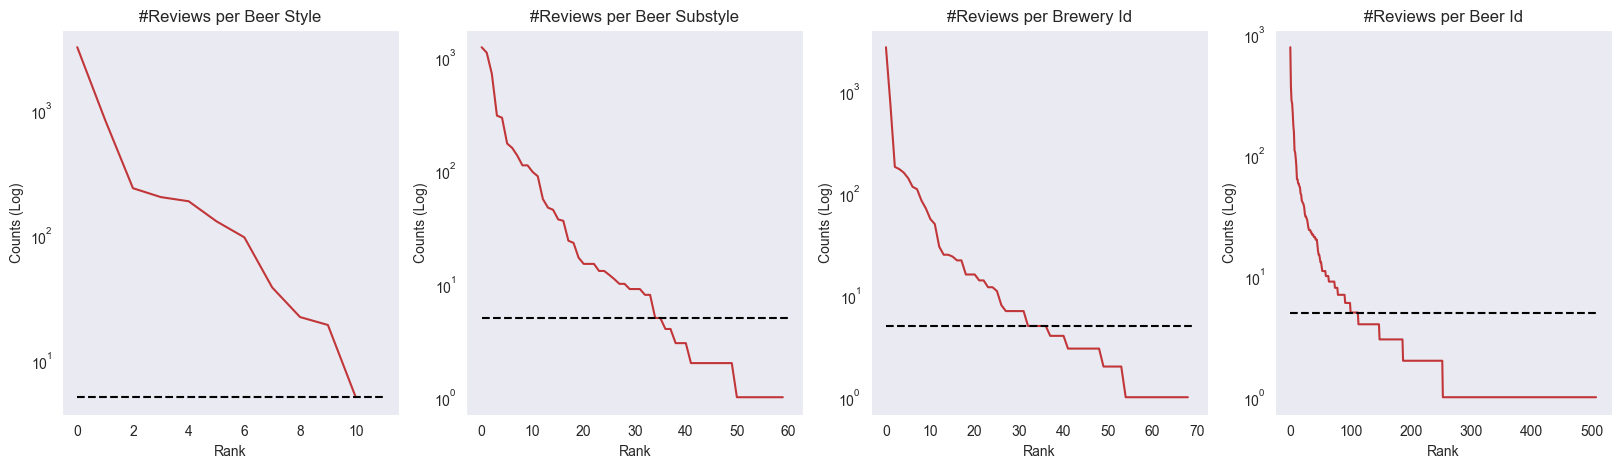

In [16]:
# Minimum number of reviews for a beer style, brewery, or beer to be included in the analysis
MIN_REVIEWS = 5

# Compute the number of reviews for each element in each group
reviews_per_beer_style = (
    reviews.groupby(by=("beer", "style")).size().sort_values(ascending=False)
)
reviews_per_beer_substyle = (
    reviews.groupby(by=("beer", "substyle")).size().sort_values(ascending=False)
)
reviews_per_brewery = (
    reviews.groupby(by=("brewery", "id")).size().sort_values(ascending=False)
)
reviews_per_beer = (
    reviews.groupby(by=("beer", "id")).size().sort_values(ascending=False)
)

# Plot number of reviews per beer style
fig, axs = plt.subplots(ncols=4, figsize=(20, 5))
for ax, reviews_per_group in zip(
    axs, [reviews_per_beer_style, reviews_per_beer_substyle, reviews_per_brewery, reviews_per_beer]
):
    sns.lineplot(x=range(len(reviews_per_group)), y=reviews_per_group.values, ax=ax)
    ax.plot(
        [0, len(reviews_per_group)],
        [MIN_REVIEWS, MIN_REVIEWS],
        linestyle="--",
        color="black",
    )
    a, b = reviews_per_group.index.names[0]
    ax.set(
        title=f"#Reviews per {a.capitalize()} {b.capitalize()}",
        xlabel="Rank",
        ylabel="Counts (Log)",
        yscale="log",
    )

In [17]:
# Filter out beer styles with less than MIN_REVIEWS reviews
included_beer_styles = reviews_per_beer_style[
    reviews_per_beer_style >= MIN_REVIEWS
].index
included_breweries = reviews_per_brewery[reviews_per_brewery >= MIN_REVIEWS].index
included_beers = reviews_per_beer[reviews_per_beer >= MIN_REVIEWS].index

# Create masks for filtering out beer styles with less than MIN_REVIEWS reviewsk
min_reviews_beer_style_mask = reviews.beer["style"].isin(included_beer_styles)
min_reviews_breweries_mask = reviews.brewery["id"].isin(included_breweries)
min_reviews_beer_mask = reviews.beer["id"].isin(included_beers)

# Filter out reviews for beer styles with less than MIN_REVIEWS reviews
original_reviews = reviews.copy()
reviews = reviews[
    min_reviews_beer_style_mask & min_reviews_breweries_mask & min_reviews_beer_mask
].reset_index()

print(
    f"✅ Filtering done. Reviews after filtering: {len(reviews)} (Removed {len(original_reviews) - len(reviews)} reviews)"
)

✅ Filtering done. Reviews after filtering: 4356 (Removed 644 reviews)


### Reviews Statistics

The textual reviews are central to our analysis and we will be using them to
extract the taste descriptors. Let's look at some statistics about the reviews
to ensure that they are of good quality.


In [18]:
# Let's show some example reviews
pd.DataFrame(reviews.review.head(10)["text"])

,text
0,This was a 12 oz bottle poured into a snifter.It pours a dark brown with some clarity but not truly transparent. It has a frothy head with mild re...
1,Poured from a 12 ounce bottle into a pilsner glass.A: A finger of creamy head with clear-dark amber body.S: Rich brown sugar. Malty...T: Slight su...
2,Beer poured from bottle into a Nonic shaped pint glassA - Beer pours with a dark creme/brownish colored head; about 1/2 finger in size; no lacing;...
3,"Pours a rich brownish red with some chill haze and a big off-white head. Some lace.Some caramel, toffee, butter, and toasted malt. Some burnt suga..."
4,Appearance: These Strangford Lough beers pour very nicely and this one pours a clear copper; while its head is not as impressive as the St. Patric...
5,"Six pack from George's deli case, always some oddball beer in there. Brewed in Rochester, NY, per the label. &quot;1060&quot; Julian date on the n..."
6,"Poured from a bottle into a tumbler pint, the beer is a dark, ruby-copper coloring with a thin, off-white, low profile, foamy head. Aromas are sup..."
7,"A- Pours a dark brownish red with a nice creamy head that dissipates quickly, but leaves a small ring and some lacing.S &amp; T- A fine, sweet car..."
8,"Poured into a Jail House Brewery tumbler. The appearance was of a deep copper or amber, with a bubbly thick one inch head with good lacing through..."
9,"Pours a nice clear mahogany with a fluffy, if not too persistent, pale tan head. Malty aroma has apple and spice hints and is inviting if not stro..."


We see that this random sample of 10 reviews consists only of reviews that are
very detailed and descriptive about the beer and its taste. This suggests that
the majority of reviews are of good quality and suited for our analysis.
However, we suspect that there might be some meaningless "spam" reviews that may
skew our results. We will investigate this by checking for outliers in the
review length. We use simple proxies for review length, namely the number of
words and characters in the review.


,count,mean,std,min,25%,50%,75%,max
Character Lengths,4356.0,727.438705,455.542905,137.0,426.0,613.5,888.0,4868.0
Word Lengths,4356.0,126.076217,80.055848,17.0,73.0,106.0,156.0,874.0


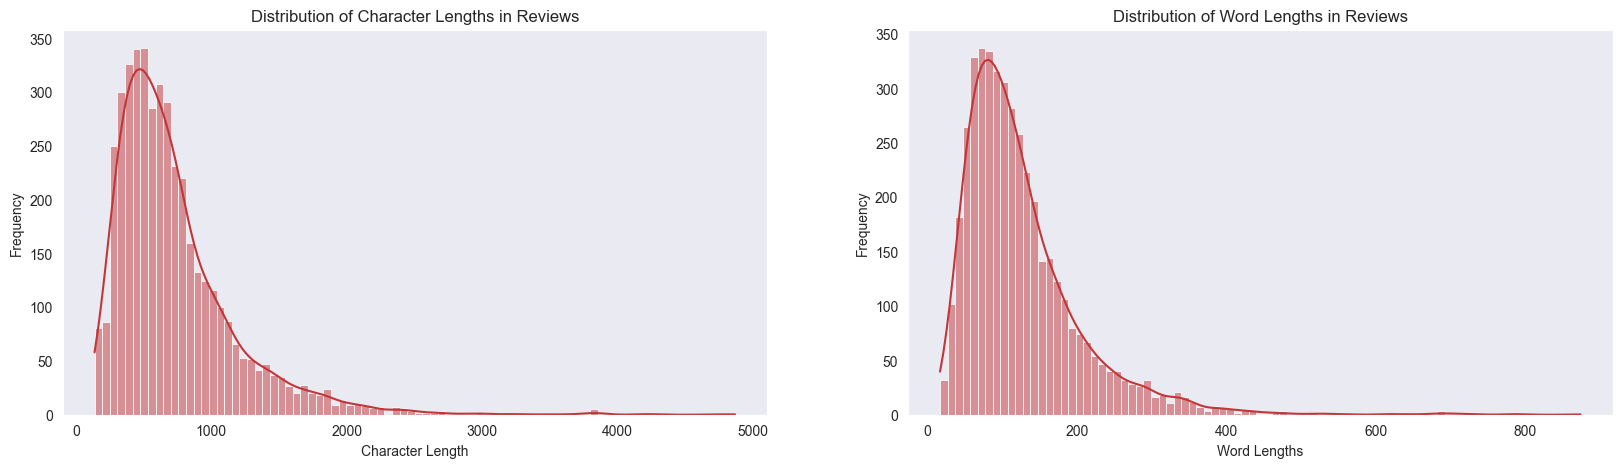

In [19]:
# Compute character and word lengths of reviews
character_lengths = reviews.review.text.str.len()
word_lengths = reviews.review.text.apply(lambda x: len(x.split()))

# Distribution of the number of ratings/ reviews per user
fig, ax = plt.subplots(ncols=2, figsize=(20, 5))
sns.histplot(x=character_lengths, kde=True, ax=ax[0])
sns.histplot(x=word_lengths, kde=True, ax=ax[1])

character_lengths_stats = character_lengths.describe()
word_lengths_stats = word_lengths.describe()

ax[0].set(
    title="Distribution of Character Lengths in Reviews",
    xlabel="Character Length",
    ylabel="Frequency",
)
ax[1].set(
    title="Distribution of Word Lengths in Reviews",
    xlabel="Word Lengths",
    ylabel="Frequency",
)

# Show summary statistics
pd.DataFrame(
    [character_lengths_stats, word_lengths_stats],
    index=["Character Lengths", "Word Lengths"],
)

We see that most reviews are around **~408 characters** and **~123 words** long.
There is a slight right-skew in the distribution, meaning that there are some
very long reviews. The very short reviews are probably not very helpful for our
analysis as the numeric representation will not be meaningful. Let's look at
those reviews to see if further processing is required.


In [20]:
# Show the shortest 0.1% of reviews (by character count)
n = int(len(reviews) * 0.001)
character_sorted = list(character_lengths.sort_values().index.values)
shortest_character_length_reviews = reviews.review[
    reviews.index.isin(character_sorted[:n])
]

pd.DataFrame(shortest_character_length_reviews.text)

,text
1221,"From bottle, pours a cloudy golden colour with a good white head.Aroma pineapple, citrus, malt, grass.Taste citrus, orange, grass, straw, malt, sp..."
1289,"**12/24/2016Bottle to snifter.Dark black, no head...right to lacing.Toasty barleyLight fruit finishA little Smokey. From the scotch, **"
2080,Black and blacker.Prunes and figs.Hint of chocolate. Some oak with a touch of Scotch. Light peat. Subtle.Mild and long. Sweet but not sticky.Excel...
2087,Less richness in aroma although more smoke and scotch on the palate compared to 12 and 18. Maintains its gritty feel and lack of head and carbona...


In [21]:
# Show the shortest 0.1% of reviews (by word count)
n = int(len(reviews) * 0.001)
words_sorted = list(word_lengths.sort_values().index.values)
shortest_word_length_reviews = reviews.review[reviews.index.isin(
    words_sorted[:n])]

pd.DataFrame(shortest_word_length_reviews.text)

,text
918,"From a bottle in Edinburgh. Looks like a lager; excellent clarity.Smells like an APA, with herbal/fruity hops dominating. Medium-light body with m..."
1221,"From bottle, pours a cloudy golden colour with a good white head.Aroma pineapple, citrus, malt, grass.Taste citrus, orange, grass, straw, malt, sp..."
1289,"**12/24/2016Bottle to snifter.Dark black, no head...right to lacing.Toasty barleyLight fruit finishA little Smokey. From the scotch, **"
4163,"Was really pleased with this one, smooth, drinkable, and definitely unique. Check out my review on The First Draft! http://firstdraftbeer.net/2015..."


Upon inspecting the shortest reviews, we can see that most of the shortest
reviews by character count are actually regular reviews that are just short.
However, in the reviews with very little words we can see some "spam" reviews
that are not very helpful for our analysis. It is likely that our extractors are
going to struggle with these kinds of reviews. Therefore, we remove all reviews
that have less than `10` words.


In [22]:
# Remove the shortest reviews by word count from the dataset
MIN_WORDS = 10
not_filtered_review = reviews.copy()
reviews = reviews[word_lengths >= MIN_WORDS]

print(
    f"Removed {(word_lengths < MIN_WORDS).sum()} reviews with less than {MIN_WORDS} words ✅"
)
print(f"Number of reviews: {len(reviews)}")

Removed 0 reviews with less than 10 words ✅
Number of reviews: 4356


## Components

---


### Extractors

Before we embed reviews into a numerical representation, we preprocess them
using different **extractors modules**. For this project, we have considered the
following method:

(1) `DummyExtractor`: This is a dummy extractor that does not do any
preprocessing. It simply returns the input text as is.

(2) `LemmaExtractor`: Tokenizes the text and then uses only _lemmas_ of the
extracted tokens. A lemma is the base form of a word. For example, the lemma of
**was** is **be**. Thus, the `LemmaExtractor` might be thougt of as a text
normaliser which maps all tokens to the normalised space.

(3) `AdjectiveExtractor`: As the name suggests, extract tokens which were
classified by `spaCy` as **adjectives**.


In [23]:
# Define all extractor models
extractor_models: list[extractors.ExtractorBase] = [
    extractors.DummyExtractor(),
    extractors.LemmaExtractor(),
    extractors.AdjectiveExtractor(),
]

We want to understand the behaviour of each of the extractors in detail. To do
this, we process an example review.


In [24]:
# Define demo review
demo_review = """Pours with a frothy head then settles to a thin head with thin lacing. 
Transparent. Golden to bronze in color. Dry grains. 
Light notes of citrus - orange. Pilsner-esque. Very light malt sweetness - caramel. 
Moves to a dry hoppy-ness. Light bodied. Dry. Somewhat chalky. Meh. 
Just average. Not one I would suggest to a friend, but thank for the organic 
ingredients.
"""

# Preprocess the example with Spacy
processed_demo_review = [NLP(demo_review)]

In [25]:
# Run the extractors against the example
transformed_all = []
for extractor in extractor_models:
    transformed_example = extractor.transform(processed_demo_review)
    transformed_all.append(transformed_example[0])

Starting with the `DummyExtractor`, we can use it as a reference baseline for
the other two extractors.


In [26]:
print("DummyExtractor:\n", transformed_all[0].strip())

DummyExtractor:
 Pours with a frothy head then settles to a thin head with thin lacing. 
Transparent. Golden to bronze in color. Dry grains. 
Light notes of citrus - orange. Pilsner-esque. Very light malt sweetness - caramel. 
Moves to a dry hoppy-ness. Light bodied. Dry. Somewhat chalky. Meh. 
Just average. Not one I would suggest to a friend, but thank for the organic 
ingredients.


Let's look at the `LemmaExtractor` next.


In [27]:
print("LemmaExtractor\n", transformed_all[1].strip())

LemmaExtractor
 pour with a frothy head then settle to a thin head with thin lacing . 
 Transparent . golden to bronze in color . dry grain . 
 Light note of citrus - orange . Pilsner - esque . very light malt sweetness - caramel . 
 move to a dry hoppy - ness . Light body . Dry . somewhat chalky . Meh . 
 just average . not one I would suggest to a friend , but thank for the organic 
 ingredient .


As the text below shows, `LemmaExtractor` has normalised the words to their base
form (lemma), a couple of examples:

(1) `grains` -> `grain` (get rid of the plural form)

(2) `settles` -> `settle` (remove `s` from the he/she/it form)

(3) `bodied` -> `body` (stem form)

Apart from the lemmatisation, we can also see that how `spaCy` tokenizes the
text. In particular, it treats punctuation marks as separate tokens. For
example, `.` is a separate token.


Lastly, we run the `AdjectiveExtractor` on the example review.


In [28]:
print("AdjectiveExtractor\n", transformed_all[2].strip())

AdjectiveExtractor
 frothy thin thin Golden Dry orange esque light dry chalky average organic


Finally, looking at the `AdjectiveExtractor`, we can see that it strips the text
to only adjectives, thereby potentially losing some useful information. On the
other hand, for the purposes of our analysis, this might be in fact useful as we
only want our embeddings be based on the descriptive words related to beer and
avoid the noise.


Now, we will run the extractors against the reviews and show the word frequency
and the 10 most frequent words for each extractor.


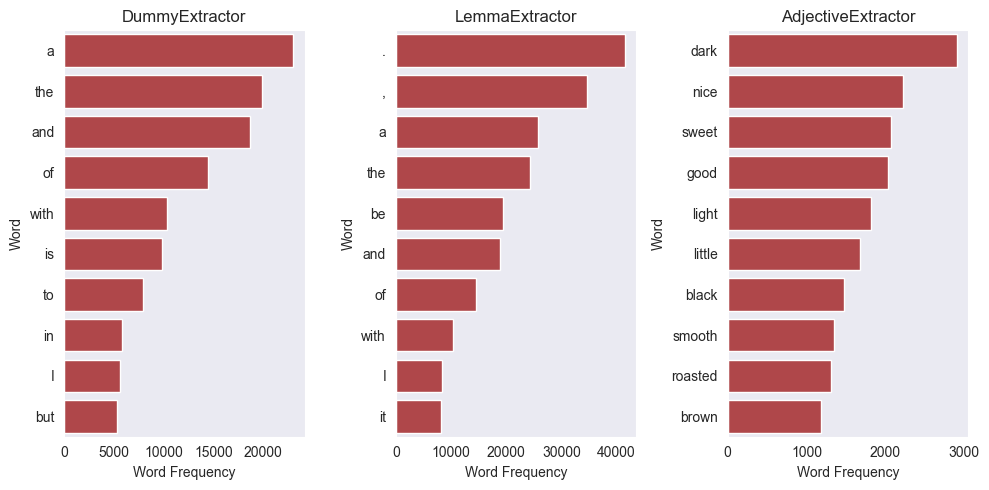

In [29]:
# We map the list of docs to the list of preprocessed strings
extracted_reviews = [
    extractor.transform(reviews.review.doc) for extractor in extractor_models
]
frequencies = [utils.get_word_frequency(text) for text in extracted_reviews]

# Plot the word frequency of top-10 words for each extractor
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for ax, freq, extractor in zip(axes, frequencies, extractor_models):
    sns.barplot(x="frequency", y="word", data=freq.head(10), ax=ax)
    ax.set_title(extractor.name)
    ax.set_xlabel("Word Frequency")
    ax.set_ylabel("Word")

plt.tight_layout()

In summary, each of the extractors works as expected. Given the manual
inspection of the extraction process, we hypothesise that the
`AdjectiveExtractor` is the most suitable one for our task because the
adjectives are most related to the taste of a beer. Thus, numerically
representing only the subset of adjectives is going to be the closest proxy to
an embedding of the beer's taste.


### Embedders

We need an embedding module to turn the extracted information from the reviews
into a numeric representation. Let's go over how each one works.

- CountEmbeddors uses sklearn's
  [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html).
  Count vectorisation simply assigns each word in the vocabulary to a variable
  in the feature vector, and the values are the counts of each word.

- TFIDF is similar to CountVectorizer, but also multiplies by an 'inverse
  document frequency' term. This weights a word in the vocabular by how
  frequently it appears in the corpus. Very common words are penalised, and
  rarer words are given more weight. This also uses sklearn's
  [TFIDFVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).
  This is done using the following formula:

$$w_{i,j} = tf_{i,j} \times \frac{N}{df_i}$$

where $w_{i,j}$ denotes the TFIDF of the $i$ th term in review $j$, $tf_{i,j}$
is the 'term frequency' (the count vectorization) of term $i$ in review $j$, $N$
is the total number of reviews and $df_i$ is the 'document frequency' of term
$i$ i.e. the number of documents in which $i$ appears. This second half of the
equation corresponds to the 'inverse document frequency' (IDF) of TFIDF.

- BERTEmbeddor uses `bert-base-uncased`
  [from HuggingFace](https://huggingface.co/bert-base-uncased). BERT is a
  bidirectional encoder-only transformer. There are many options for extracting
  embeddings from the model since there are 12 layers, and an embbedding for
  each token input. Currently, the implementation takes the penultimate hidden
  state of the model and takes the mean across all tokens in the input (see
  [this guide](https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/)).

- SentenceTransformerEmbeddor uses the recommended `all-MiniLM-L6-v2` model from
  the `sentence-transformers`
  [library](<(https://www.sbert.net/docs/pretrained_models.html)>). These models
  take outputs from BERT, conduct pooling similar to above (e.g. by default,
  mean of last layer), and are trained on various sentence-related NLP problems
  using
  [Siamese networks](https://towardsdatascience.com/a-friendly-introduction-to-siamese-networks-85ab17522942).


Let's initialize the embedder models and run them first on some dummy reviews
and then a small sample of the actual reviews.


In [30]:
# Initalise embedders
embedding_models: list[embedders.EmbedderBase] = [
    embedders.CountEmbedder(),
    embedders.TfidfEmbedder(sparse_output=False),
    embedders.BertEmbedder(),
    embedders.SentenceTransformerEmbedder(),
]

First, we compute the cosine similary between the first sentence and each
subsequent sentence for each of the embedding models.


In [31]:
# Create a dataframe with some sample reviews
embedder_demo = pd.DataFrame(
    {
        "text": [
            "The beer is nice, with sweet nutty flavours",
            "This is a very different sentence",
            "Not sweet enough. I like my beer sweet. ",
            "Not sweet at all. Terrible beer. ",
            "Not sweet at all. But I like bitter beers so it is a nice beer. ",
            "Piss yellow beer",
            "Sweet beer",
        ]
    }
)

# Initialise results dataframe
results = pd.DataFrame(
    index=[model.name for model in embedding_models],
    columns=[f"Similarity {i}" for i in range(1, len(embedder_demo))],
)

# Compute the similarity between the first and the nth sentence
for i in range(1, len(embedder_demo)):
    for model in embedding_models:
        similarity = utils.compute_similarity(
            model, embedder_demo["text"][0], embedder_demo["text"][i]
        )
        results.loc[model.name, f"Similarity {i}"] = similarity

print("Similarity between first and nth sentence:")
results.head()

Similarity between first and nth sentence:


,Similarity 1,Similarity 2,Similarity 3,Similarity 4,Similarity 5,Similarity 6
CountEmbedder,0.158114,0.353553,0.288675,0.392232,0.204124,0.5
TfidfEmbedder,0.087044,0.224413,0.170776,0.248458,0.116718,0.379978
BertEmbedder,0.617567,0.79183,0.791252,0.828123,0.721489,0.776372
SentenceTransformerEmbedder,0.094767,0.667616,0.69976,0.718871,0.334227,0.650784


Here we can see the obvious pitfall of using CountVectorizer and TFIDF - they
lose all context. Sentences 3 and 4 would ideally have the lowest similairty
with sentence 1 since they are opposite in meaning. However, these samples all
use the same words which Count and TFIDF interpret as therefore being similar.
If, during the pipeline, we were to group beers by some measure that affects
their sweetness, then in order to confirm out hypothesis we would like to see an
increase of similarity inside each group, but we may lower similarity due to
negations.

However, BERT and SentenceTransformers are not necessarily better. The values
are far less interpretable, with sentence embeddor falling for a similar
negation trap since similarities 3 and 4 are higher than 7. Interestingly,
SentenceTransformer was far better than BERT at differentiating between
sentences on different topic matters (similarity 2). BERT's scores are all
broadly similar, and roughly gets the order in line what we might expect, but we
have little faith that this translates any better than sentence transformer to
the real reviews since these little samples play into BERT's context-aware
strengths.

However, for now, we will try to make conclusions using tf-idf. It is the most
interpretable (we can get out the most impactful words at the end), and so long
as there are enough reviews that are long enough, we should see a meaningful
vocabulary emerge. If the tfidf embeddings seem to be limiting us in the future,
we can experiment with other methods.


Now let's try with some real sample reviews.


In [32]:
# Create a dataframe with some sample reviews
embedder_sample = pd.DataFrame(
    {"text": reviews.sample(4, random_state=0).review.text.values.tolist()}
)

# Initialise results dataframe
results = pd.DataFrame(
    index=[model.name for model in embedding_models],
    columns=[f"Similarity {i}" for i in range(1, len(embedder_sample))],
)

# Compute the similarity between the first and the nth sentence
for i in range(1, len(embedder_sample)):
    for model in embedding_models:
        similarity = utils.compute_similarity(
            model, embedder_sample["text"][0], embedder_sample["text"][i]
        )
        results.loc[model.name, f"Similarity {i}"] = similarity

print("Similarity between first and nth sentence:")
results.head()

Similarity between first and nth sentence:


,Similarity 1,Similarity 2,Similarity 3
CountEmbedder,0.411076,0.435522,0.375816
TfidfEmbedder,0.293295,0.296301,0.266628
BertEmbedder,0.871539,0.853088,0.871593
SentenceTransformerEmbedder,0.725678,0.633841,0.546559


Unsurprisinlgy, Count and TFIDF agree on ordering of similarity. However, BERT
and SentenceTransformer disagree both with this ordering and each other. BERT is
the less 'sure', with very high and close values, as in the previous example.

Reading the reviews, it's very hard to define what the ordering _should_ be,
therefore it is hard to define which embedder has done a better job in this
sample. Further investigation will be carried out for P3.


### Consensus Clustering

The final step in the pipeline is to compute the consensus scores for a set of
beer reviews. These are implemented as child classes of the
`consensus.ConsensusBase` class. Currently, we have implemented the following
consensus functions:

- `CosineSimilarity`: Computes the pairwise cosine similarity between all
  reviews in a set of reviews. The consensus score is the mean of all pairwise
  cosine similarities.


In [34]:
# Initialise the consensus models
consensus_models: list[ConsensusBase] = [
    CosineSimilarity(),
]

## Analysis

---



Due to the large size of the dataset, we will now load precomputed embeddings of all of the reviews. These embeddings were computed using the `AdjectiveExtractor` and `TFIDFEmbeddor`, for this you also need to have all the reviews preporcessed with the using Spacy.


In [35]:
# Load all reviews and emebddings
reviews_all = utils.load_data(PROCESSED_DIR, None, False, None)
embeddings_all = utils.load_embeddings(PROCESSED_DIR, None)  # sparse matrix
assert len(reviews_all) == embeddings_all.shape[0]
print(f"✅ Loaded {len(reviews_all)} reviews and embeddings.")


# Filter out beer styles with less than MIN_REVIEWS reviews
MIN_REVIEWS = 50
MAX_REVIEWS = 1000
MIN_WORDS = 50
embeddings_all, reviews_all = utils.filter_data(
    embeddings_all, reviews_all, MIN_REVIEWS, MAX_REVIEWS, MIN_WORDS
)  # Add min words filter
assert len(reviews_all) == embeddings_all.shape[0]
print(f"✅ Filtered {len(reviews_all)} reviews and embeddings.")

# Shuffle the embeddings to prove that the effect isn't random
if SHUFFLE_REVIEWS:
    random_indices = np.random.permutation(embeddings_all.shape[0])
    embeddings_all = embeddings_all[random_indices]
    print(f"✅ Shuffled embeddings.")

✅ Loaded 2400935 reviews and embeddings.
✅ Filtered 1508251 reviews and embeddings.


In [36]:
# Embed into 2 dimensions
# We are using truncated SVD instead of PCA because the embeddings are sparse
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
reduced_embeddings = svd.fit_transform(embeddings_all)
reduced_embeddings.shape

(1508251, 2)

### Embedding visualisation
Here we chose the three very popular beer styles `Indian Pale Ale`, `Stouts and Porters` and `Lagers and Pilsners` and from each of these it's most represented substyle and beer.

In [66]:

styles = ["India Pale Ales (IPAs)", "Stouts and Porters", "Pale Lagers and Pilsners"]
substyle = ["American IPA", "American Double / Imperial Stout", "German Pilsener"]
beers = [
    "Northern Hemisphere Harvest Wet Hop IPA",
    "Founders KBS (Kentucky Breakfast Stout)",
    "Prima Pils",
]
groups = [styles, substyle, beers]
aggregators = [("beer", "style"), ("beer", "substyle"), ("beer", "name")]

Let's understand the embeddings a bit better by plotting them in 2D using SVD. 

In [55]:
# Embed into 2 dimensions
# We are using truncated SVD instead of PCA because the embeddings are sparse
svd = TruncatedSVD(n_components=2, n_iter=50, random_state=42)
reduced_embeddings = svd.fit_transform(embeddings_all)
reduced_embeddings.shape

(1508251, 2)

In [72]:
n = len(groups)
colors = sns.color_palette("husl", n_colors=n)
group_colors = [dict(zip(group, colors)) for group in groups]

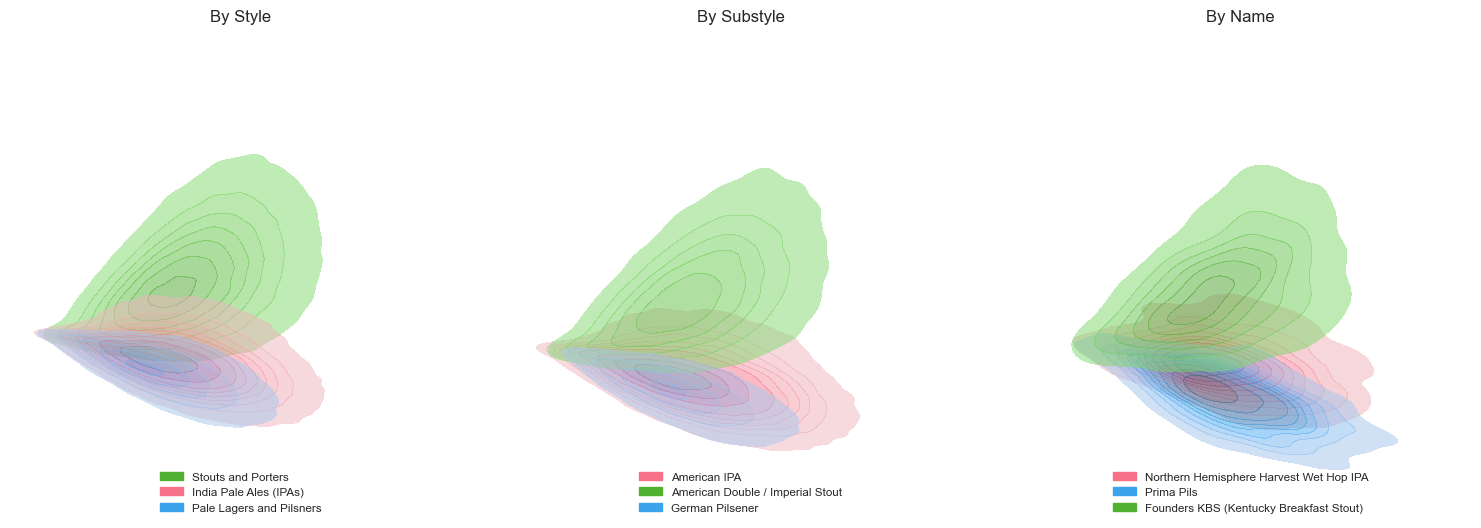

In [73]:
fig, axs = plt.subplots(ncols=len(aggregators), figsize=(5 * len(aggregators), 5))
fig.tight_layout(pad=0)

for i, (ax, agg, group) in enumerate(zip(axs, aggregators, groups)):
    subset = reviews_all[reviews_all[agg].isin(group)].index
    colors = group_colors[i]
    visualise.embeddings(
        title=f"By {agg[1].capitalize()}",
        embeddings=reduced_embeddings,
        hue=reviews_all[agg],
        subset=subset,
        plot_type="kde",
        fill=True,
        alpha=0.5,
        plot_legend=True,
        ax=ax,
        color_palette=colors,
    )

Here we plot the same thing just as a scetter plot 💔

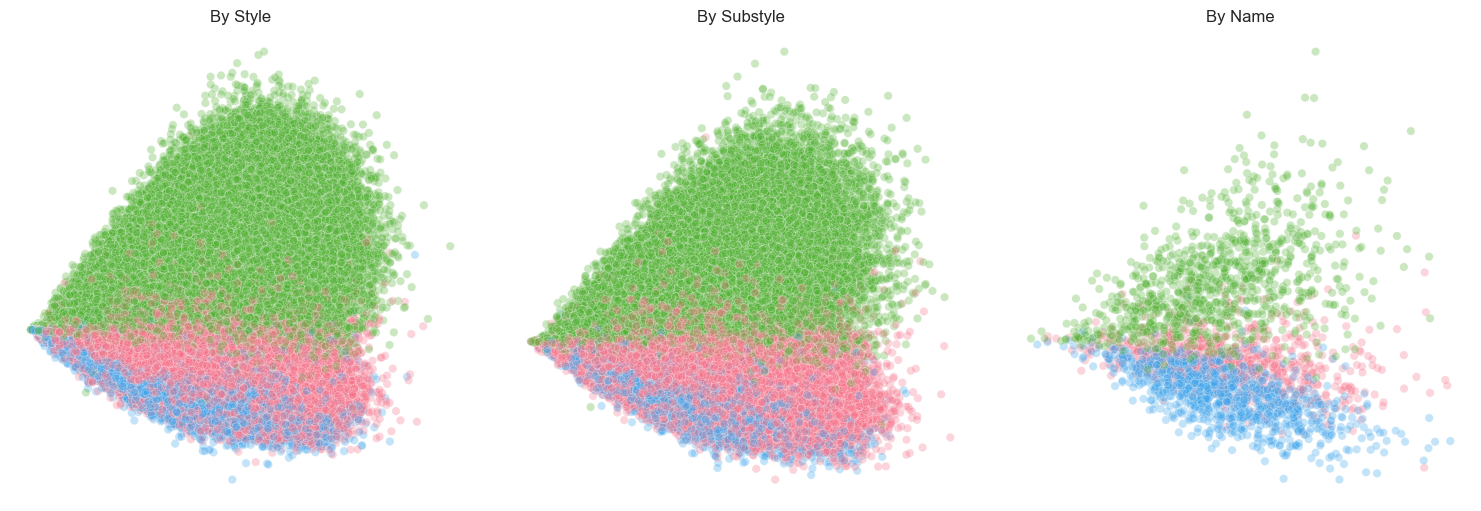

In [74]:
fig, axs = plt.subplots(ncols=len(aggregators), figsize=(5 * len(aggregators), 5))
fig.tight_layout(pad=0)
for i, (ax, agg, group) in enumerate(zip(axs, aggregators, groups)):
    subset = reviews_all[reviews_all[agg].isin(group)].index

    cmap = sns.cubehelix_palette(start=0, light=1, as_cmap=True)
    visualise.embeddings(
        title=f"By {agg[1].capitalize()}",
        embeddings=reduced_embeddings,
        hue=reviews_all[agg],
        subset=subset,
        plot_type="scatter",
        # fill=True,
        alpha=0.3,
        color_palette=group_colors[i],
        plot_legend=False,
        ax=ax,
    )

### Consensus

In [41]:
# Initialise the consensus models
consensus: ConsensusBase
if METRIC == "cosine":
    consensus = CosineSimilarity()
elif METRIC == "kl":
    consensus = KullbackLeiblerDivergence()
elif METRIC == "js":
    consensus = JensenShannonDivergence()
elif METRIC == "correlation":
    consensus = Correlation()
else:
    raise ValueError(f"Unknown metric {METRIC}")
print(f"✅ Using {type(consensus).__name__} consensus.")

✅ Using CosineSimilarity consensus.


Let's not initialise the group consensus helper class, which will allow us to easily retrieve the consensus matrix for each group at the different levels of aggregation.

In [42]:
# Initialise the aggregators
beer_aggregator = EmbeddingAggregator(
    embeddings_all, reviews_all, consensus, ("beer", "name")
)
style_aggregator = EmbeddingAggregator(
    embeddings_all, reviews_all, consensus, ("beer", "style")
)
substyle_aggregator = EmbeddingAggregator(
    embeddings_all, reviews_all, consensus, ("beer", "substyle")
)
gereral_aggregator = EmbeddingAggregator(embeddings_all, reviews_all, consensus, None)

print(f"ℹ️ Beer groups: {len(beer_aggregator.groups)}")
print(f"ℹ️ Style groups: {len(style_aggregator.groups)}")
print(f"ℹ️ Substyle groups: {len(substyle_aggregator.groups)}")
print(f"ℹ️ General groups: {len(gereral_aggregator.groups)}")

ℹ️ Beer groups: 7766
ℹ️ Style groups: 11
ℹ️ Substyle groups: 103
ℹ️ General groups: 1


Let's compute some numeric statistics for the consensus distributions for each group.

In [43]:
# Make a nice df
levels = ["General", "Style", "Substyle", "Beer"]
consensus_levels = [
    gereral_aggregator,
    style_aggregator,
    substyle_aggregator,
    beer_aggregator,
]
MAX_SAMPLES = 10000
consensus_df = []
for level, consensus_level in zip(levels, consensus_levels):
    for group in tqdm(consensus_level.groups, desc=f"Processing Group {level}"):
        con = consensus_level.get_consensus_distribution(
            group, max_samples=MAX_SAMPLES
        ).mean()

        consensus_df.append(
            {
                "level": level,
                "group": group,
                "consensus": con,
            }
        )
        dis = consensus_level.get_embeddings_by_group(group).mean(axis=0)

consensus_df = pd.DataFrame(consensus_df)
print(f"️✅ Created consensus dataframe of shape {consensus_df.shape}.")

Processing Group General:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Group Beer: 100%|██████████| 7766/7766 [12:52<00:00, 10.06it/s]

️✅ Created consensus dataframe of shape (7881, 3).


In [45]:
# Sort by levels list
level_stats = consensus_df.groupby(by=["level"]).describe().reindex(levels, level=0)
level_stats

consensus                                                    \
             count      mean       std       min       25%       50%   
level                                                                  
General        1.0  0.055801       NaN  0.055801  0.055801  0.055801   
Style         11.0  0.064998  0.009535  0.050114  0.062786  0.064058   
Substyle     103.0  0.076353  0.017106  0.051032  0.065069  0.070513   
Beer        7766.0  0.086014  0.021451  0.041836  0.071150  0.081228   

                              
               75%       max  
level                         
General   0.055801  0.055801  
Style     0.065919  0.089056  
Substyle  0.085049  0.137817  
Beer      0.096837  0.234561

While the consensus score does not change a lot, the mean consensus across
all groups increases with increasing specificity of the grouping. This is promising
for confirming our hypothesis that language used differs between beer types.


✅ Plotted distribution of all consensus scores in levels.


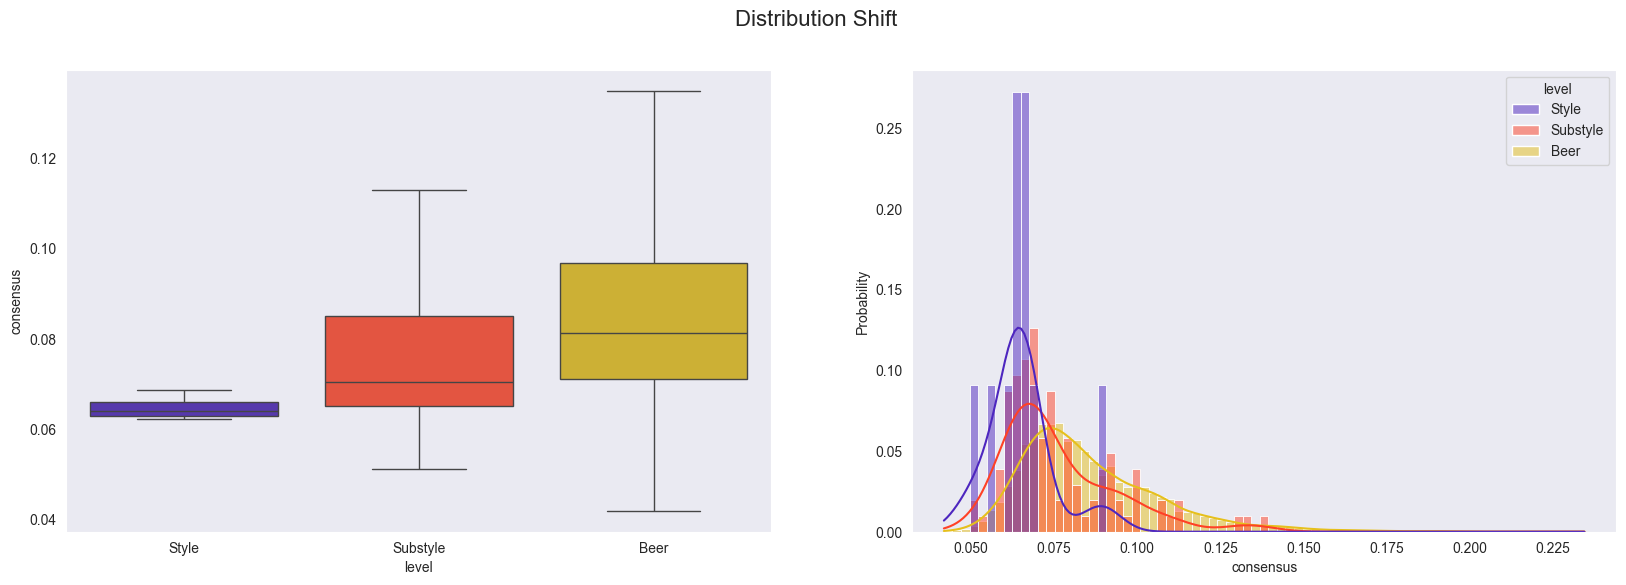

In [46]:
# Plot distributions of mean consensus scores
fig, axs = plt.subplots(ncols=2, figsize=(20, 6))
fig.suptitle("Distribution Shift", fontsize=16)

# Boxplot of consensus scores per level
sns.boxplot(
    data=consensus_df[consensus_df["level"] != "General"],
    x="level",
    y="consensus",
    hue="level",
    order=levels[1:],
    showfliers=False,
    palette="CMRmap",
    ax=axs[0],
)

# Distplot of consensus scores per level
sns.histplot(
    data=consensus_df[consensus_df["level"] != "General"],
    x="consensus",
    hue="level",
    stat="probability",
    kde=True,
    fill=True,
    common_norm=False,
    palette="CMRmap",
    ax=axs[1],
)

print(f"✅ Plotted distribution of all consensus scores in levels.")

### Statistical Tests

We pefrom a statistical test with the null hypothesis that the average consensus scores in each level of grouping are the same. We use the ANOVA test to test this hypothesis at the 1% significance level. We have different number of samples in each group, so we use the type 2 ANOVA test which is more robust to unequal sample sizes. [Source](https://www.r-bloggers.com/2011/03/anova-%e2%80%93-type-iiiiii-ss-explained/)

In [47]:
# We first need to fit an OLS model
model = ols("consensus ~ C(level)", data=consensus_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
C(level),0.015183,3.0,11.061992,3.040729e-07
Residual,3.603797,7877.0,NaN,NaN


In [48]:
print(
    f"The test statistic is {anova_table.iloc[0]['F']:.2f} and the p-value is {anova_table.iloc[0]['PR(>F)']:.2f}."
)

The test statistic is 11.06 and the p-value is 0.00.


In [49]:
turkey_results = pairwise_tukeyhsd(
    consensus_df["consensus"], consensus_df["level"], alpha=0.01
)
turkey_results.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Beer,General,-0.0302,0.4915,-0.0968,0.0364,False
Beer,Style,-0.021,0.0062,-0.0411,-0.0009,True
Beer,Substyle,-0.0097,0.0,-0.0163,-0.0031,True
General,Style,0.0092,0.9765,-0.0604,0.0788,False
General,Substyle,0.0206,0.7743,-0.0464,0.0875,False
Style,Substyle,0.0114,0.3378,-0.0098,0.0325,False
